# Importación de bibliotecas

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree

# Preprocesamiento
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Cross validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

# Modelo red neuronal
import tensorflow as tf
from tensorflow import keras

# Carga de datos y pasos previos al entrenamiento

Importamos el dataset filtrado para comenzar a trabajar

In [5]:
ds_hotel=pd.read_csv('./hotels_train_filtrado3.csv')
ds_trabajo = ds_hotel.copy()

Aplicamos One-Hot Encoding para trabajar con las variables categóricas antes de entrenar nuestros modelos

In [6]:
# ONE HOT ENCODING ...
ds_trabajo_encoded = pd.get_dummies(ds_trabajo, columns=['hotel',
                                                 'market_segment',
                                                 'distribution_channel',
                                                 'is_repeated_guest',
                                                 'deposit_type',
                                                 'customer_type',
                                                 'agent_specified',
                                                 'more_than_zero_days_in_waiting_list',
                                                 'season',
                                                 'region',
                                                 'room_type_match'], drop_first=True)
ds_trabajo_encoded.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,previous_cancellations,previous_bookings_not_canceled,booking_changes,adr,total_of_special_requests,is_canceled,arrival_date,...,agent_specified_1,more_than_zero_days_in_waiting_list_1,season_Spring,season_Summer,season_Winter,region_Americas,region_Asia,region_Europe,region_Oceania,room_type_match_True
0,1.633333,1.0,2.0,0.0,0,0,115.5,1,1,1.473034e+09,...,1,0,0,1,0,1,0,0,0,1
1,0.133333,0.0,1.0,0.0,0,0,42.0,0,0,1.446250e+09,...,0,0,0,0,0,0,0,1,0,1
2,0.833333,0.0,1.0,0.0,0,0,229.0,2,0,1.476317e+09,...,1,0,0,0,0,0,0,1,0,1
3,0.866667,2.0,5.0,0.0,0,0,75.0,0,1,1.481501e+09,...,1,0,0,0,0,0,0,1,0,1
4,3.466667,2.0,5.0,0.0,0,0,75.0,1,0,1.489882e+09,...,1,0,0,0,1,0,0,1,0,1


In [7]:
ds_trabajo_encoded.columns

Index(['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'booking_changes', 'adr', 'total_of_special_requests', 'is_canceled',
       'arrival_date', 'total_guests', 'hotel_Resort Hotel',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'market_segment_Others',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'is_repeated_guest_1',
       'deposit_type_Non Refund', 'customer_type_Transient',
       'customer_type_Transient-Party', 'agent_specified_1',
       'more_than_zero_days_in_waiting_list_1', 'season_Spring',
       'season_Summer', 'season_Winter', 'region_Americas', 'region_Asia',
       'region_Europe', 'region_Oceania', 'room_type_match_True'],
      dtype='object')

Generamos el código para mostrar las métricas y la matriz de confusión de nuestras predicciones 

In [8]:
def mostrar_metricas(y_test, y_pred):
  print(classification_report(y_test,y_pred))

  # Calcular las métricas de evaluación
  accuracy = accuracy_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Imprimir las métricas de evaluación
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("f1 score:", f1)

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

Como Keras no tiene una métrica F1 score predefinida para  utilizar al momento de compilar redes neuronales, vamos a definir una función externa a la biblioteca que calcula el F1 score, basándonos en la implementación que se muestra en [este artículo](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d).

In [14]:
import keras.backend as K
def get_f1(y_true, y_pred): # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Modelo de Redes Neuronales

Vamos a normalizar los datos para que todas las características tengan una escala similar y no dominen unas sobre otras durante el entrenamiento de nuestras redes neuronales y para mejorar su rendimiento. Lo aplicamos luego de hacer la división train-test con proporción 70/30.

In [9]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Creo un dataset con los features que voy a usar para clasificar
ds_trabajo_x = ds_trabajo_encoded.drop(['is_canceled'], axis='columns')

# Creo un dataset con la variable target
ds_trabajo_y = ds_trabajo_encoded['is_canceled'].copy()

# Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,
                                                    random_state=2)

# Armo una versión estandarizada
stand_scaler = preprocessing.StandardScaler()
x_train_norm = pd.DataFrame(stand_scaler.fit_transform(x_train), columns=x_train.columns)
x_test_norm = pd.DataFrame(stand_scaler.transform(x_test), columns=x_test.columns)


## Modelo 1: capa de entrada, capa de salida, SGD optimizer

Observamos que nuestra red neuronal tendrá 32 neuronas de entrada y dos clases para la salida.

In [10]:
# Cantidad de clases de salida
cant_clases=len(np.unique(y_train))
# Cantidad de columnas de entrada
d_in=len(x_train_norm.columns)

print(f"Cantidad de neuronas de entrada: {d_in}")
print(f"Cantidad de clases de salida: {cant_clases}")

Cantidad de neuronas de entrada: 32
Cantidad de clases de salida: 2


Vamos a empezar entrenando una red neuronal densa simple que sólo tenga dos capas: la de entrada y la de salida. Vamos a usar la función de activación sigmoide en la capa de entrada

In [11]:
modelo_rn_1 = keras.Sequential([
    keras.layers.Dense(1, activation='sigmoid', input_shape=(d_in,))
])

modelo_rn_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


Compilamos el modelo.

In [15]:
modelo_rn_1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='binary_crossentropy', 
  metrics=[get_f1], 
)

Y lo entrenamos.

In [16]:
modelo_rn_1.fit(x_train_norm, y_train, batch_size=32, epochs=15, validation_data=(x_test_norm, y_test))

Epoch 1/15
1355/1355 [==============================] - 4s 2ms/step - loss: 0.5297 - get_f1: 0.7116 - val_loss: 0.4916 - val_get_f1: 0.7396
Epoch 2/15
1355/1355 [==============================] - 3s 2ms/step - loss: 0.4842 - get_f1: 0.7371 - val_loss: 0.4831 - val_get_f1: 0.7437
Epoch 3/15
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4790 - get_f1: 0.7404 - val_loss: 0.4798 - val_get_f1: 0.7443
Epoch 4/15
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4764 - get_f1: 0.7411 - val_loss: 0.4777 - val_get_f1: 0.7479
Epoch 5/15
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4746 - get_f1: 0.7446 - val_loss: 0.4764 - val_get_f1: 0.7460
Epoch 6/15
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4734 - get_f1: 0.7454 - val_loss: 0.4751 - val_get_f1: 0.7474
Epoch 7/15
1355/1355 [==============================] - 2s 2ms/step - loss: 0.4724 - get_f1: 0.7461 - val_loss: 0.4741 - val_get_f1: 0.7494
Epoch 8/15
1355/1355

Hacemos la predicción, convirtiendo las salidas continuas en predicciones binarias utilizando un umbral. Dado que creemos que es importante reducir los falsos negativos en el problema de predecir el estado de cancelación de reservas (es decir, queremos minimizar la clasificación incorrecta de reservas que en realidad serían canceladas, vamos a definir este umbral por debajo de 0.5, siendo así el modelo más permisivo al clasificar las reservas como canceladas. Analizamos las métricas obtenidas para distintos valores del umbral y observamos que con 0.4 mantenemos un recall y un f1 score similares.

581/581 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      9195
           1       0.76      0.76      0.76      9378

    accuracy                           0.76     18573
   macro avg       0.76      0.76      0.76     18573
weighted avg       0.76      0.76      0.76     18573

Accuracy: 0.7587896408765412
Recall: 0.7638089144806995
Precision: 0.7597581671616461
f1 score: 0.7617781559076889


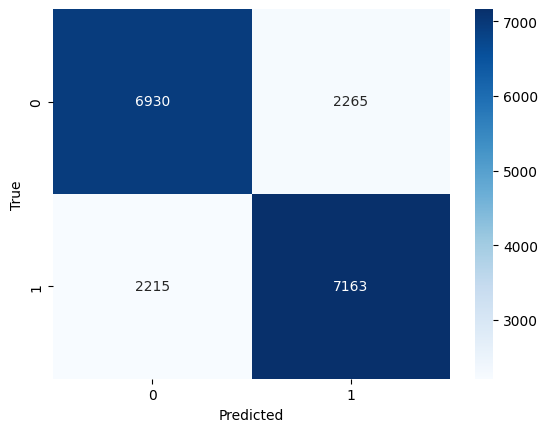

In [17]:
y_pred_norm = modelo_rn_1.predict(x_test_norm)
y_pred = np.where(y_pred_norm > 0.45, 1, 0)
mostrar_metricas(y_test, y_pred)